In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,10 #sets figure size
from keras.models import Sequential #defines a linear stack of layers for deep learning models
from keras.layers import LSTM,Dropout,Dense,Input
# LSTM = great for sequential data like stock prices
# Dropout = tool used to help prevent overfitting by randomly dropping connections in the neural network
# Dense = a fully connected layer

from sklearn.preprocessing import MinMaxScaler #normalisation technique

In [4]:
dataset=pd.read_csv("NSE-TATA-Global-Beverages-Limited.csv")
dataset.head() #returns first 5 rows of dataframe by default

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


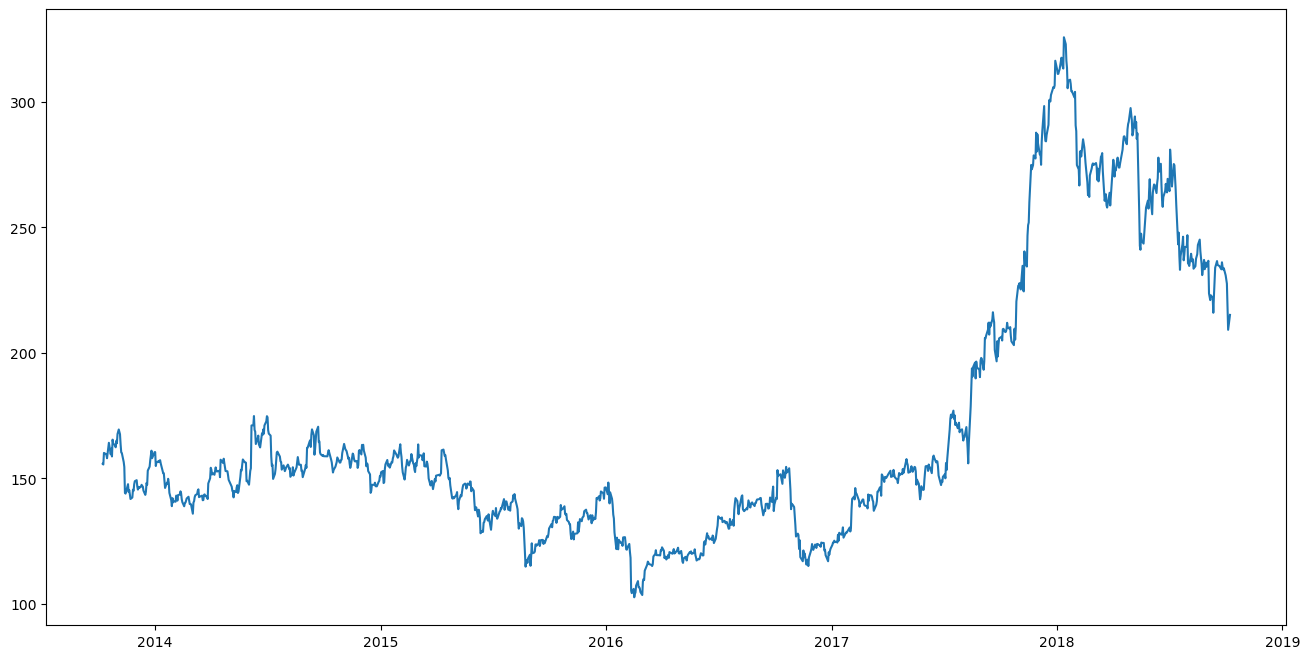

In [5]:
dataset["Date"]=pd.to_datetime(dataset.Date,format="%Y-%m-%d") #converts date column into python datetime objects 
dataset.index = dataset["Date"] #sets reference tag by data so not 0 1 2 3 but dates
dataset2 = dataset.sort_index()

plt.figure(figsize=(16,8))
plt.plot(dataset2["Close"],label="Close price history")
plt.show()


In [6]:
data = dataset.sort_index(ascending=True,axis=0)  #sorts index in ascending order axis = 0 means sorting rows not column
new_dataset =pd.DataFrame(index=range(0,len(dataset)), columns = ['Date','Close']) #creates new dataframe rows from 0 to len of dataset with 2 columns date and close

for i in range(len(data)):
    new_dataset.loc[i, "Date"] = data.iloc[i]["Date"]
    new_dataset.loc[i, "Close"] = data.iloc[i]["Close"]


# for i in range(0,len(data)):
    #new_dataset["Date"][i]=data['Date'][i]
    #new_dataset["Close"][i]=data['Close'][i]




In [7]:
scaler=MinMaxScaler(feature_range=(0,1)) #scaler that transforms all values to fall between 0 and 1

new_dataset.index=new_dataset["Date"] #sets as index or first column but u also still have date column 2 too
new_dataset.drop("Date",axis=1,inplace=True) #drops 2nd date column inplace = true modifies the dataframe directly so doesnt make a dupe
final_dataset=new_dataset.values

train_data=final_dataset[0:987,:] #train data is from 1 to 987
valid_data=final_dataset[987:,:] #valid data is from everything from 987 to after that 

scaled_data=scaler.fit_transform(final_dataset) #apply the scaler

x_train_data,y_train_data=[],[] #initialise list

for i in range(60,len(train_data)): #creating a sliding window of 60 previous time steps the first instance where there are 60 timesteps before is at 60
    x_train_data.append(scaled_data[i-60:i,0]) #so when i = 60 i-60 = 0 so it goes from 0 to 59  second i is just the stop
    y_train_data.append(scaled_data[i,0]) #so here it would write i = 60 which would give the 61st box
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data) #convert to numpy array 

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
#lstm espects 3 things samples,timesteps, features
#so that line is reshaping it to become 3D

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/indexes/base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


In [8]:
lstm_model=Sequential()
lstm_model.add(Input(shape=(60, 1)))  # Explicit input layer
lstm_model.add(LSTM(units=50,return_sequences=True))
#add layers to keras sequential
#use lstm
#50 hidden lstm cells, will extract features from input sequence
#return_sequences=True means that we will output the full sequence of outputs for each input sequence
#input_shape is the shape of the input data, which is (number of time steps,number of features)
lstm_model.add(LSTM(units=50)) #second layer of lstm
lstm_model.add(Dense(1)) #output layer

inputs_data = new_dataset[len(new_dataset)-len(valid_data)-60:].values
#new_dataset is the entire dataset with 'close'
#valid_data = validation data
# -60 -60 first -60 is to move index to where the validation data starts
# another -60 to move index back another 60 before validation starts
# so 1047 rows -60  = 987 rows where validation starts
# - 60 again to gather that data for input cant predict 987 without 60 before it
#converts to numpy array
input_data = inputs_data.reshape(-1,1) #reshape to 2D array
# -1 means that the number of rows is inferred from the shape of the array
# 1 means that the number of columns is 1   
inputs_data = scaler.transform(inputs_data)
#transforms the data to the same scale as the training data
#so that the model can make predictions on the validation data

lstm_model.compile(optimizer='adam',loss='mean_squared_error')
#optimizer is the optimizer to use
#loss is the loss function to use
#adam is a good optimizer for regression problems
#mean_squared_error is a good loss function for regression problems
#fit the model
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)
#x_train_data is the training data
#y_train_data is the training data
#epochs is the number of times to train the model so only goes through it once
#batch_size is the number of samples to train on at a time so 1 means that the model updates it weight after each sample so stochastic gradient descent
#verbose is the verbosity of the output
#2 means that the output will be printed



927/927 - 8s - 9ms/step - loss: 0.0010


In [10]:
X_test = []
for i in range(60,inputs_data.shape[0]): #60 is the number of previous days we want to consider
    X_test.append(inputs_data[i-60:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [12]:
lstm_model.save("saved_model.keras")

/var/folders/kj/56t962452cxcbkfl7t7kklw40000gp/T/ipykernel_55005/1632976719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


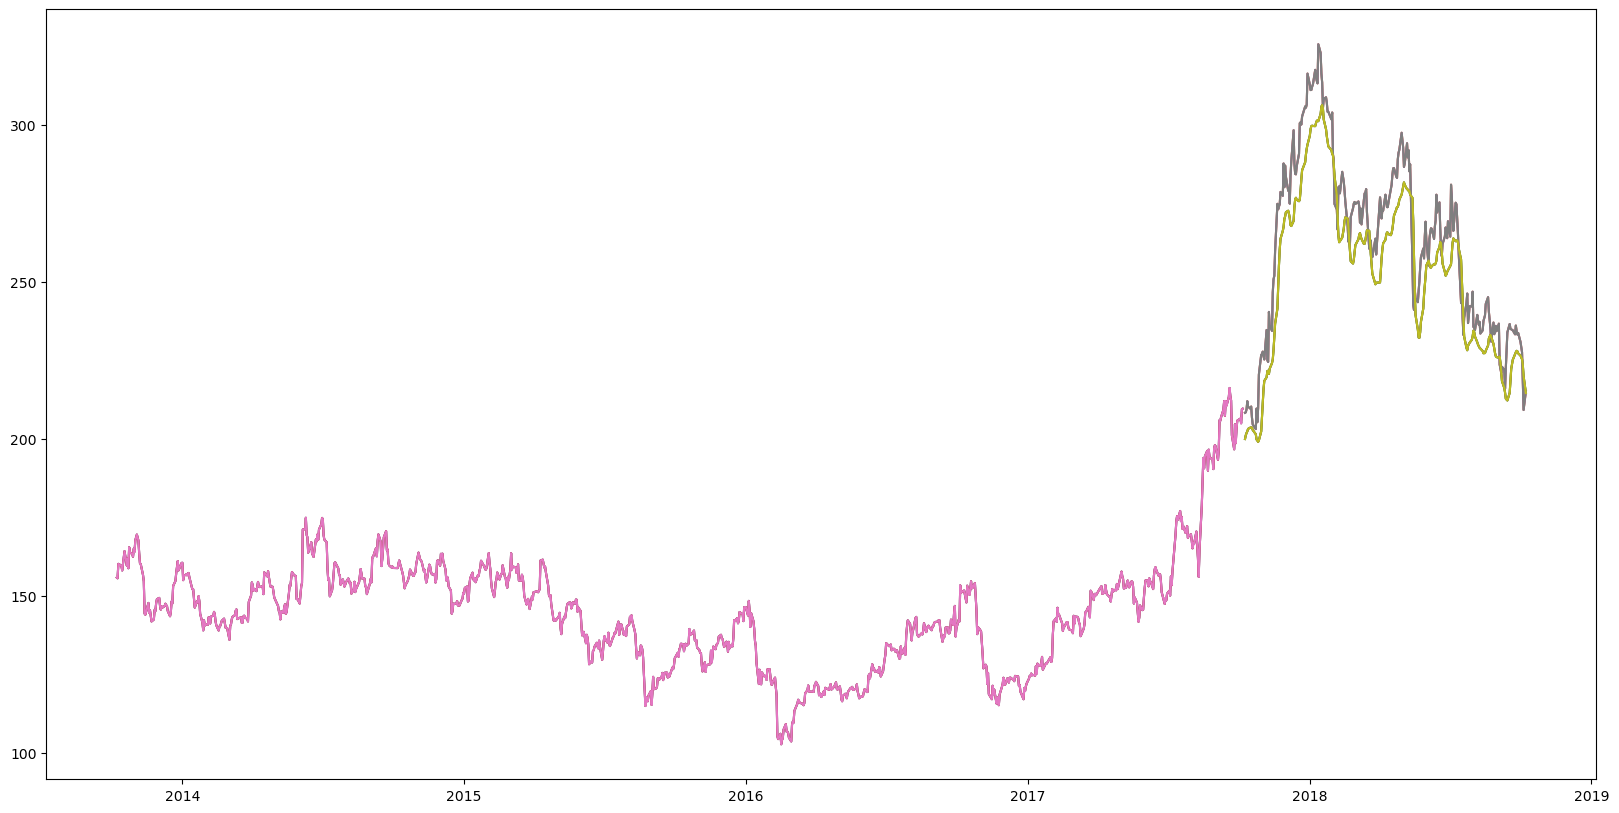

In [15]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
plt.show()